In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

In [2]:
data8 = pd.read_csv('C:/Users/daini/OneDrive/Dators/ai/MachineLearningCSV/MachineLearningCVE/CICIDS2017_sample.csv')

In [3]:
data_combined = data8

rows, cols = data_combined.shape
print(f'Number of rows: {rows}, Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

# Noņemam liekās atstarpes no kolonnu nosaukumiem
col_names = {col: col.strip() for col in data_combined.columns}
data_combined.rename(columns = col_names, inplace = True)

data_combined.columns

Number of rows: 50024, Number of columns: 79
Total cells: 3951896


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [4]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50024 entries, 0 to 50023
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Destination Port             50024 non-null  int64  
 1   Flow Duration                50024 non-null  int64  
 2   Total Fwd Packets            50024 non-null  int64  
 3   Total Backward Packets       50024 non-null  int64  
 4   Total Length of Fwd Packets  50024 non-null  int64  
 5   Total Length of Bwd Packets  50024 non-null  int64  
 6   Fwd Packet Length Max        50024 non-null  int64  
 7   Fwd Packet Length Min        50024 non-null  int64  
 8   Fwd Packet Length Mean       50024 non-null  float64
 9   Fwd Packet Length Std        50024 non-null  float64
 10  Bwd Packet Length Max        50024 non-null  int64  
 11  Bwd Packet Length Min        50024 non-null  int64  
 12  Bwd Packet Length Mean       50024 non-null  float64
 13  Bwd Packet Lengt

In [5]:
# Pirms datu apstrādes
print(data_combined['Label'].value_counts())

BENIGN        25000
DoS           11299
PortScan       7102
DDoS           5798
BruteForce      647
WebAttack        97
Bot              81
Name: Label, dtype: int64


In [6]:
# Daru tīrīšana
# Dublētu vērtību identificēšana
dups = data_combined[data_combined.duplicated()]
print(f'Dublikātu skaits: {len(dups)}')

Dublikātu skaits: 2907


In [7]:
# Noņemam visus dubultos ierakstus
data_combined.drop_duplicates(inplace = True)
data_combined.shape

(47117, 79)

In [8]:
# Trūkstošo vērtību noteikšana
missing_val = data_combined.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    7
dtype: int64


In [9]:
# Bezgalības vērtību pārbaude
numeric_cols = data_combined.select_dtypes(include = np.number).columns
inf_count = np.isinf(data_combined[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      18
Flow Packets/s    25
dtype: int64


In [10]:
# Jebkuru bezgalīgu vērtību (pozitīvu vai negatīvu) aizstāšana ar NaN (nevis skaitli)
print(f'Trūkstošās vērtības: {data_combined.isna().sum().sum()}')

data_combined.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Pēc bezgalīgu vērtību apstrādes trūkstošo vērtību skaits: {data_combined.isna().sum().sum()}')

Trūkstošās vērtības: 7
Pēc bezgalīgu vērtību apstrādes trūkstošo vērtību skaits: 50


In [11]:
# Identificējam un saskaitītām trūkstošās vērtības
missing = data_combined.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      25
Flow Packets/s    25
dtype: int64


In [12]:
# Trūkstošo vērtību procentuālās daļas aprēķināšana
mis_per = (missing / len(data_combined)) * 100
print(mis_per[mis_per > 0].round(2))

Flow Bytes/s      0.05
Flow Packets/s    0.05
dtype: float64


In [13]:
# Mediānas noteikšana
med_flow_bytes = data_combined['Flow Bytes/s'].median()
med_flow_packets = data_combined['Flow Packets/s'].median()

# Trūkstošo vērtību aizpildīšana ar mediānu
data_combined['Flow Bytes/s'] = data_combined['Flow Bytes/s'].fillna(med_flow_bytes)
data_combined['Flow Packets/s'] = data_combined['Flow Packets/s'].fillna(med_flow_packets)

print('Trūkstošo \'Flow Bytes/s\' vērtību skaits:', data_combined['Flow Bytes/s'].isna().sum())
print('Trūkstošo \'Flow Packets/s\' vērtību skaits:', data_combined['Flow Packets/s'].isna().sum())

Trūkstošo 'Flow Bytes/s' vērtību skaits: 0
Trūkstošo 'Flow Packets/s' vērtību skaits: 0


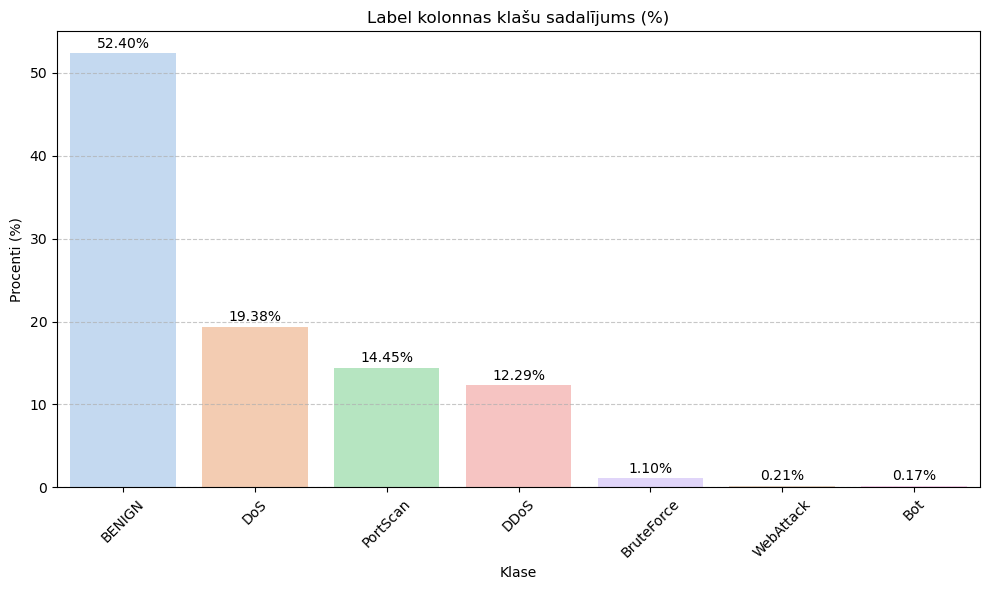

In [14]:
# Aprēķina klašu sadalījumu
label_counts = data_combined['Label'].value_counts()
label_percent = label_counts / label_counts.sum() * 100
df_labels = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values, 'Percentage': label_percent.values})

# Zīmē stabiņu diagrammu
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    data=df_labels,
    x='Label',
    y='Percentage',
    hue='Label',
    palette='pastel',
    alpha=0.7,
    legend=False
)

# Pievieno procentu anotācijas virs stabiņiem
for bar, percent in zip(bars.patches, df_labels['Percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f'{percent:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Label kolonnas klašu sadalījums (%)')
plt.ylabel('Procenti (%)')
plt.xlabel('Klase')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


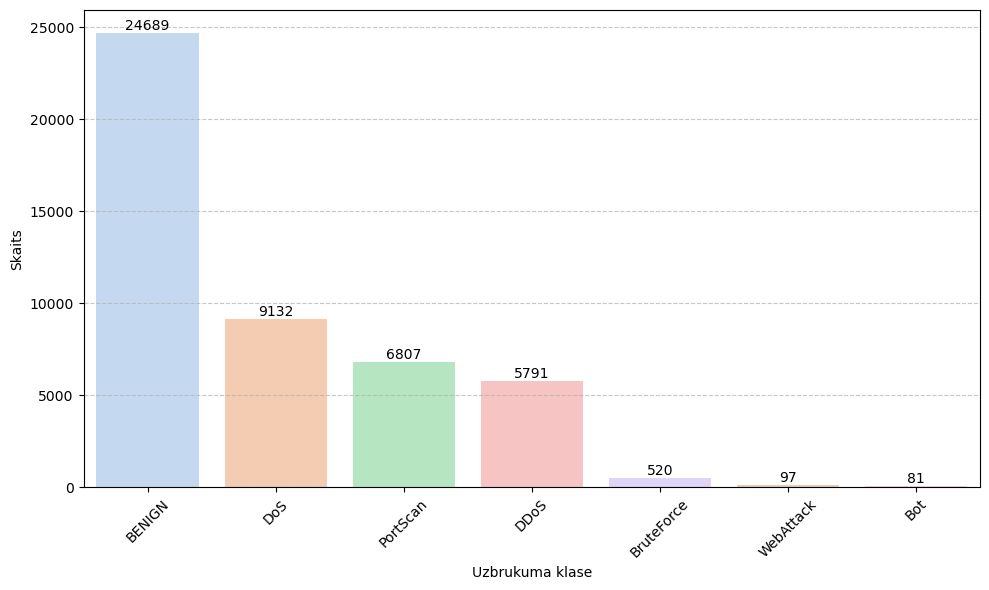

In [15]:
# Filtrē datus, izņemot 'BENIGN'

# Aprēķina klašu skaitu tikai uzbrukumiem
label_counts = data_combined['Label'].value_counts()
df_labels = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})

# Zīmē stabiņu diagrammu ar skaitliskām vērtībām
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    data=df_labels,
    x='Label',
    y='Count',
    hue='Label',
    palette='pastel',
    alpha=0.7,
    legend=False
)

# Pievieno skaitliskās vērtības virs stabiņiem
for bar, count in zip(bars.patches, df_labels['Count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3, f'{count}', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Skaits')
plt.xlabel('Uzbrukuma klase')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
print("Gala parauga lielums:", len(data_combined))
print(data_combined['Label'].value_counts())

Gala parauga lielums: 47117
BENIGN        24689
DoS            9132
PortScan       6807
DDoS           5791
BruteForce      520
WebAttack        97
Bot              81
Name: Label, dtype: int64


In [17]:
# Atdalām iezīmes (X) un mērķa mainīgo (y)
X = data_combined.drop(['Label'], axis=1)
y = data_combined['Label']

# Standartizējam datu iezīmes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Vienots KFold sadalītājs visiem modeļiem
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [19]:
for i, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    total = len(train_index) + len(test_index)
    print(f"Fold {i+1}: Train = {len(train_index)}, Test = {len(test_index)}")

Fold 1: Train = 42405, Test = 4712
Fold 2: Train = 42405, Test = 4712
Fold 3: Train = 42405, Test = 4712
Fold 4: Train = 42405, Test = 4712
Fold 5: Train = 42405, Test = 4712
Fold 6: Train = 42405, Test = 4712
Fold 7: Train = 42405, Test = 4712
Fold 8: Train = 42406, Test = 4711
Fold 9: Train = 42406, Test = 4711
Fold 10: Train = 42406, Test = 4711


In [20]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree modelis
dt = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42)

dt_scores = cross_validate(dt, X_scaled, y, cv=kf, scoring='accuracy', return_train_score=False)

print(f"Decision Tree vidējais apmācības laiks: {dt_scores['fit_time'].mean():.4f} s")
print(f"Decision Tree vidējais testēšanas laiks: {dt_scores['score_time'].mean():.4f} s")
print(f"Decision Tree kopējais izpildes laiks: {(dt_scores['fit_time'].sum() + dt_scores['score_time'].sum()):.4f} s")
print("-------------------------------")
print(f"Decision Tree 10-fold Cross-Validation Scores: {dt_scores['test_score']}")
print(f"Mean cross-validation accuracy: {dt_scores['test_score'].mean():.4f} ± {dt_scores['test_score'].std():.4f}")

Decision Tree vidējais apmācības laiks: 0.6780 s
Decision Tree vidējais testēšanas laiks: 0.0039 s
Decision Tree kopējais izpildes laiks: 6.8185 s
-------------------------------
Decision Tree 10-fold Cross-Validation Scores: [0.93909168 0.90938031 0.92657046 0.93760611 0.93060272 0.93739389
 0.93548387 0.93207387 0.93377202 0.93865421]
Mean cross-validation accuracy: 0.9321 ± 0.0084


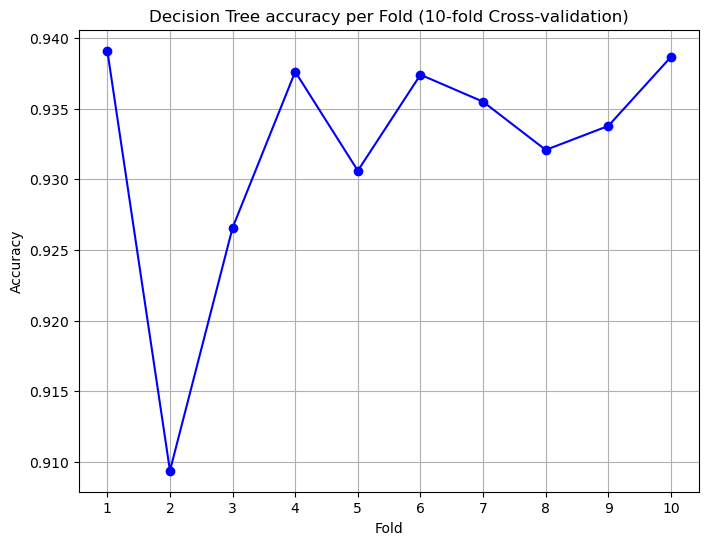

In [21]:
# Latentā precizitāte (katram fold)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), dt_scores['test_score'], marker='o', linestyle='-', color='b')
plt.title('Decision Tree accuracy per Fold (10-fold Cross-validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

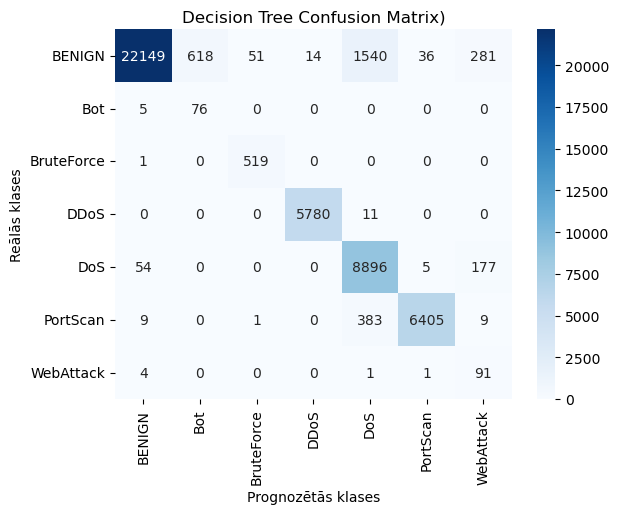

Precizitāte (accuracy): 0.9321
Decision Tree Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.90      0.94     24689
         Bot       0.11      0.94      0.20        81
  BruteForce       0.91      1.00      0.95       520
        DDoS       1.00      1.00      1.00      5791
         DoS       0.82      0.97      0.89      9132
    PortScan       0.99      0.94      0.97      6807
   WebAttack       0.16      0.94      0.28        97

    accuracy                           0.93     47117
   macro avg       0.71      0.95      0.75     47117
weighted avg       0.96      0.93      0.94     47117



In [22]:
dt_pred = cross_val_predict(dt, X_scaled, y, cv=kf)

labels = sorted(data_combined['Label'].unique())
# Confusion Matrix
cm_dt = confusion_matrix(y, dt_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prognozētās klases")
plt.ylabel("Reālās klases")
plt.title("Decision Tree Confusion Matrix)")
plt.show()

accuracy_dt = accuracy_score(y, dt_pred)
print(f"Precizitāte (accuracy): {accuracy_dt:.4f}")

# Classification Report
print("Decision Tree Classification Report:")
print(classification_report(y, dt_pred, target_names=labels))

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=16)

knn_scores = cross_validate(knn, X_scaled, y, cv=kf, scoring='accuracy', return_train_score=False)

print(f"KNN vidējais apmācības laiks: {knn_scores['fit_time'].mean():.4f} s")
print(f"KNN vidējais testēšanas laiks: {knn_scores['score_time'].mean():.4f} s")
print(f"KNN kopējais izpildes laiks: {(knn_scores['fit_time'].sum() + knn_scores['score_time'].sum()):.4f} s")
print("-------------------------------")
print(f"KNN 10-fold Cross-Validation Scores: {knn_scores['test_score']}")
print(f"Mean cross-validation accuracy: {knn_scores['test_score'].mean():.4f} ± {knn_scores['test_score'].std():.4f}")

KNN vidējais apmācības laiks: 0.0460 s
KNN vidējais testēšanas laiks: 0.3877 s
KNN kopējais izpildes laiks: 4.3367 s
-------------------------------
KNN 10-fold Cross-Validation Scores: [0.9815365  0.98026316 0.97962649 0.98259762 0.98132428 0.9815365
 0.9815365  0.98132031 0.98344301 0.97983443]
Mean cross-validation accuracy: 0.9813 ± 0.0011


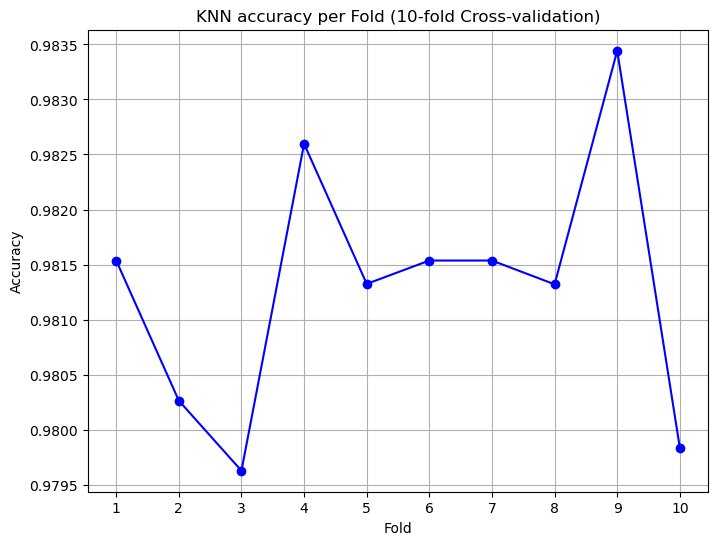

In [24]:
# Latentā precizitāte (katram fold)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), knn_scores['test_score'], marker='o', linestyle='-', color='b')
plt.title('KNN accuracy per Fold (10-fold Cross-validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

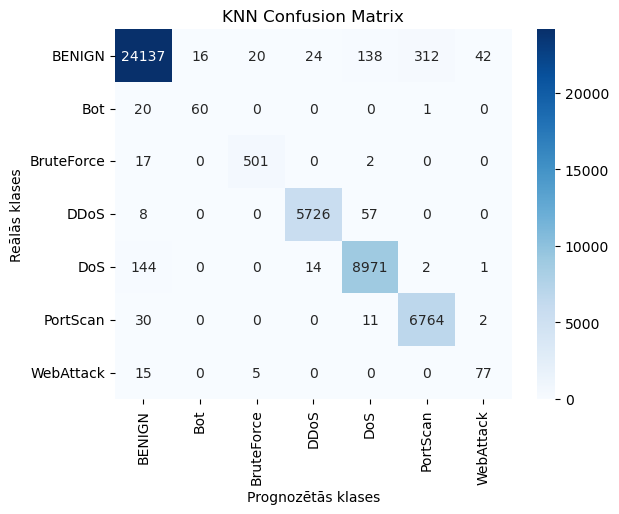

Precizitāte (accuracy): 0.9813
KNN Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.98     24689
         Bot       0.79      0.74      0.76        81
  BruteForce       0.95      0.96      0.96       520
        DDoS       0.99      0.99      0.99      5791
         DoS       0.98      0.98      0.98      9132
    PortScan       0.96      0.99      0.97      6807
   WebAttack       0.63      0.79      0.70        97

    accuracy                           0.98     47117
   macro avg       0.90      0.92      0.91     47117
weighted avg       0.98      0.98      0.98     47117



In [25]:
knn_pred = cross_val_predict(knn, X_scaled, y, cv=kf)

labels = sorted(data_combined['Label'].unique())
# Confusion Matrix
cm_knn = confusion_matrix(y, knn_pred)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prognozētās klases")
plt.ylabel("Reālās klases")
plt.title("KNN Confusion Matrix")
plt.show()

accuracy_knn = accuracy_score(y, knn_pred)
print(f"Precizitāte (accuracy): {accuracy_knn:.4f}")

# Classification Report
print("KNN Classification Report:")
print(classification_report(y, knn_pred, target_names=labels))

In [26]:
from sklearn.naive_bayes import GaussianNB
# Apmāca Gaussian Naive Bayes modeli
gnb = GaussianNB()

gnb_scores = cross_validate(gnb, X_scaled, y, cv=kf, scoring='accuracy', return_train_score=False)

print(f"Naive Bayes vidējais apmācības laiks: {gnb_scores['fit_time'].mean():.4f} s")
print(f"Naive Bayes vidējais testēšanas laiks: {gnb_scores['score_time'].mean():.4f} s")
print(f"Naive Bayes kopējais izpildes laiks: {(gnb_scores['fit_time'].sum() + gnb_scores['score_time'].sum()):.4f} s")
print("-------------------------------")
print(f"Naive Bayes 10-fold Cross-Validation Scores: {gnb_scores['test_score']}")
print(f"Mean cross-validation accuracy: {gnb_scores['test_score'].mean():.4f} ± {gnb_scores['test_score'].std():.4f}")

Naive Bayes vidējais apmācības laiks: 0.1012 s
Naive Bayes vidējais testēšanas laiks: 0.0261 s
Naive Bayes kopējais izpildes laiks: 1.2731 s
-------------------------------
Naive Bayes 10-fold Cross-Validation Scores: [0.82979626 0.81876061 0.81706282 0.82067063 0.80857385 0.82321732
 0.81748727 0.81893441 0.81638718 0.83506686]
Mean cross-validation accuracy: 0.8206 ± 0.0070


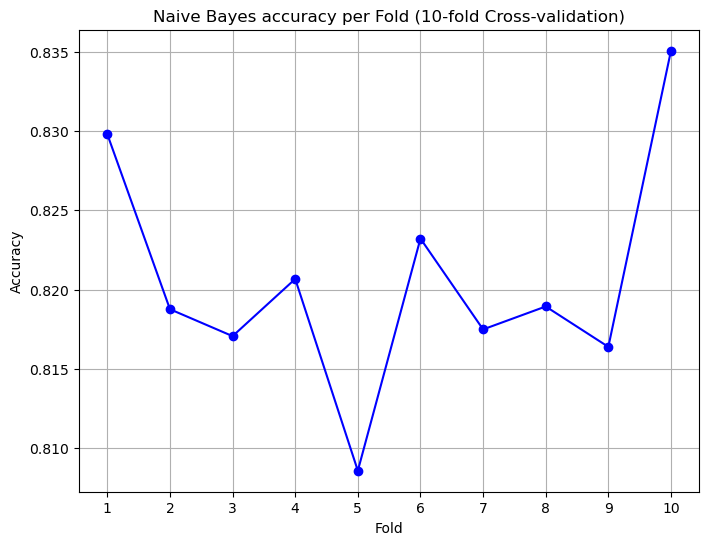

In [27]:
# Latentā precizitāte (katram fold)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), gnb_scores['test_score'], marker='o', linestyle='-', color='b')
plt.title('Naive Bayes accuracy per Fold (10-fold Cross-validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

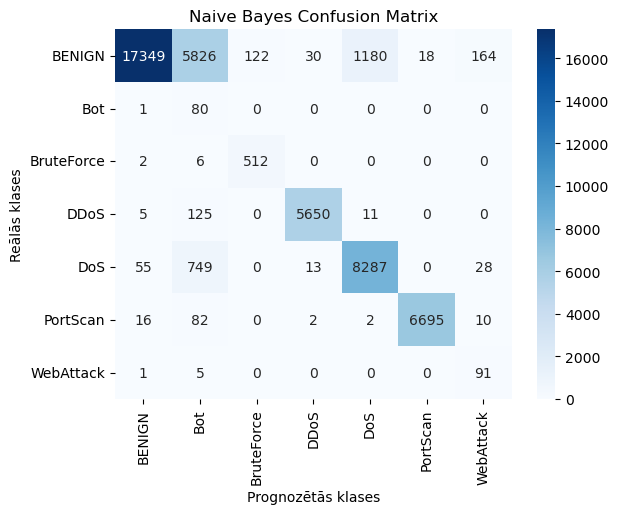

Precizitāte (accuracy): 0.8206
Naive Bayes Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.70      0.82     24689
         Bot       0.01      0.99      0.02        81
  BruteForce       0.81      0.98      0.89       520
        DDoS       0.99      0.98      0.98      5791
         DoS       0.87      0.91      0.89      9132
    PortScan       1.00      0.98      0.99      6807
   WebAttack       0.31      0.94      0.47        97

    accuracy                           0.82     47117
   macro avg       0.71      0.93      0.72     47117
weighted avg       0.97      0.82      0.88     47117



In [28]:
gnb_pred = cross_val_predict(gnb, X_scaled, y, cv=kf)

labels = sorted(data_combined['Label'].unique())
# Confusion Matrix
cm_gnb = confusion_matrix(y, gnb_pred)
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prognozētās klases")
plt.ylabel("Reālās klases")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

accuracy_gnb = accuracy_score(y, gnb_pred)
print(f"Precizitāte (accuracy): {accuracy_gnb:.4f}")

# Classification Report
print("Naive Bayes Classification Report:")
print(classification_report(y, gnb_pred, target_names=labels))

In [29]:
# PAMATOJUMS, KĀPĒC F1-score macro avg IR ĻOTI SVARĪGS
f1_macro_dt = f1_score(y, dt_pred, average='macro')
f1_macro_knn = f1_score(y, knn_pred, average='macro')
f1_macro_gnb = f1_score(y, gnb_pred, average='macro')

percent_difference_dt = ((accuracy_dt - f1_macro_dt) / accuracy_dt) * 100
percent_difference_knn = ((accuracy_knn - f1_macro_knn) / accuracy_knn) * 100
percent_difference_gnb = ((accuracy_gnb - f1_macro_gnb) / accuracy_gnb) * 100

In [30]:
print("Decision Tree Model Comparison")
print("-------------------------------")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"F1 Macro Average: {f1_macro_dt:.4f}")
print(f"Percentage Difference: {percent_difference_dt:.2f}%")

Decision Tree Model Comparison
-------------------------------
Accuracy: 0.9321
F1 Macro Average: 0.7465
Percentage Difference: 19.91%


In [31]:
print("KNN Model Comparison")
print("-------------------------------")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"F1 Macro Average: {f1_macro_knn:.4f}")
print(f"Percentage Difference: {percent_difference_knn:.2f}%")

KNN Model Comparison
-------------------------------
Accuracy: 0.9813
F1 Macro Average: 0.9078
Percentage Difference: 7.49%


In [32]:
print("Naive Bayes Model Comparison")
print("-------------------------------")
print(f"Accuracy: {accuracy_gnb:.4f}")
print(f"F1 Macro Average: {f1_macro_gnb:.4f}")
print(f"Percentage Difference: {percent_difference_gnb:.2f}%")

Naive Bayes Model Comparison
-------------------------------
Accuracy: 0.8206
F1 Macro Average: 0.7236
Percentage Difference: 11.81%


In [33]:
import re
from statistics import mean

report_text_dt = """
              precision    recall  f1-score   support

      BENIGN       1.00      0.90      0.94     24689
         Bot       0.11      0.94      0.20        81
  BruteForce       0.91      1.00      0.95       520
        DDoS       1.00      1.00      1.00      5791
         DoS       0.82      0.97      0.89      9132
    PortScan       0.99      0.94      0.97      6807
   WebAttack       0.16      0.94      0.28        97

    accuracy                           0.93     47117
   macro avg       0.71      0.95      0.75     47117
weighted avg       0.96      0.93      0.94     47117
"""

# Iegūst f1-score un support
f1_pattern = re.compile(r"^\s*(\S.*?)\s+[\d.]+\s+[\d.]+\s+([\d.]+)\s+(\d+)", re.MULTILINE)
entries_dt = f1_pattern.findall(report_text_dt)

low_support_f1_dt = []
high_support_f1_dt = []

# Izslēdzam avg un līdzīgus ierakstus
excluded_labels = {"accuracy", "macro avg", "weighted avg"}

for label, f1_str, support_str in entries_dt:
    if label in excluded_labels:
        continue
    f1 = float(f1_str)
    support = int(support_str)
    if support < 100:
        low_support_f1_dt.append(f1)
    elif support > 500:
        high_support_f1_dt.append(f1)

# Vidējo vērtību aprēķins
avg_low_f1_dt = mean(low_support_f1_dt) if low_support_f1_dt else 0
avg_high_f1_dt = mean(high_support_f1_dt) if high_support_f1_dt else 0

print(f"Vidējais F1 klasēm ar support < 100: {avg_low_f1_dt:.3f}")
print(f"Vidējais F1 klasēm ar support > 500: {avg_high_f1_dt:.3f}")

Vidējais F1 klasēm ar support < 100: 0.240
Vidējais F1 klasēm ar support > 500: 0.950


In [34]:

report_text_knn = """
KNN Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.98     24689
         Bot       0.79      0.74      0.76        81
  BruteForce       0.95      0.96      0.96       520
        DDoS       0.99      0.99      0.99      5791
         DoS       0.98      0.98      0.98      9132
    PortScan       0.96      0.99      0.97      6807
   WebAttack       0.63      0.79      0.70        97

    accuracy                           0.98     47117
   macro avg       0.90      0.92      0.91     47117
weighted avg       0.98      0.98      0.98     47117
"""

f1_pattern_knn = re.compile(r"^\s*(\S.*?)\s+[\d.]+\s+[\d.]+\s+([\d.]+)\s+(\d+)", re.MULTILINE)
entries_knn = f1_pattern_knn.findall(report_text_knn)

low_support_f1_knn = []
high_support_f1_knn = []

excluded_labels = {"accuracy", "macro avg", "weighted avg"}

for label, f1_str, support_str in entries_knn:
    if label in excluded_labels:
        continue
    f1 = float(f1_str)
    support = int(support_str)
    if support < 100:
        low_support_f1_knn.append(f1)
    elif support > 500:
        high_support_f1_knn.append(f1)

avg_low_f1_knn = mean(low_support_f1_knn) if low_support_f1_knn else 0
avg_high_f1_knn = mean(high_support_f1_knn) if high_support_f1_knn else 0

print(f"Vidējais F1 klasēm ar support < 100: {avg_low_f1_knn:.3f}")
print(f"Vidējais F1 klasēm ar support > 500: {avg_high_f1_knn:.3f}")


Vidējais F1 klasēm ar support < 100: 0.730
Vidējais F1 klasēm ar support > 500: 0.976


In [35]:
report_text_gnb = """
Naive Bayes Classification Report:
               precision    recall  f1-score   support

      BENIGN       1.00      0.70      0.82     24689
         Bot       0.01      0.99      0.02        81
  BruteForce       0.81      0.98      0.89       520
        DDoS       0.99      0.98      0.98      5791
         DoS       0.87      0.91      0.89      9132
    PortScan       1.00      0.98      0.99      6807
   WebAttack       0.31      0.94      0.47        97

    accuracy                           0.82     47117
   macro avg       0.71      0.93      0.72     47117
weighted avg       0.97      0.82      0.88     47117
"""

f1_pattern = re.compile(r"^\s*(\S.*?)\s+[\d.]+\s+[\d.]+\s+([\d.]+)\s+(\d+)", re.MULTILINE)
entries = f1_pattern.findall(report_text_gnb)

low_support_f1 = []
high_support_f1 = []

excluded_labels = {"accuracy", "macro avg", "weighted avg"}

for label, f1_str, support_str in entries:
    if label in excluded_labels:
        continue
    f1 = float(f1_str)
    support = int(support_str)
    if support < 100:
        low_support_f1.append(f1)
    elif support > 500:
        high_support_f1.append(f1)

avg_low = mean(low_support_f1)
avg_high = mean(high_support_f1)

print(f"Vidējais F1 klasēm ar support < 100: {avg_low:.3f}")
print(f"Vidējais F1 klasēm ar support > 500: {avg_high:.3f}")

Vidējais F1 klasēm ar support < 100: 0.245
Vidējais F1 klasēm ar support > 500: 0.914


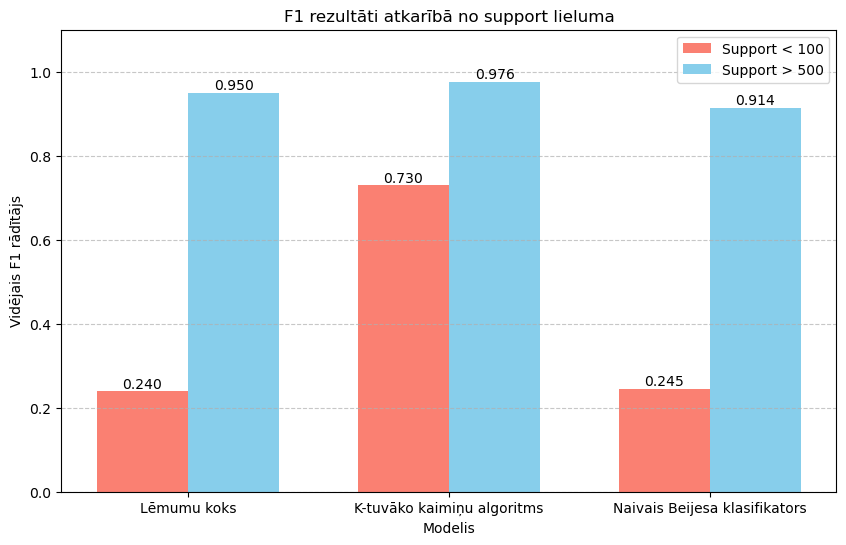

In [80]:
# Dati no trim klasifikatoriem
models = ['Lēmumu koks', 'K-tuvāko kaimiņu algoritms', 'Naivais Beijesa klasifikators']
low_support_f1 = [0.240, 0.730, 0.245]
high_support_f1 = [0.950, 0.976, 0.914]

x = range(len(models))
bar_width = 0.35

# Izveidojam stabiņu diagrammu
plt.figure(figsize=(10, 6))
bars_low = plt.bar([i - bar_width/2 for i in x], low_support_f1, width=bar_width, label='Support < 100', color='salmon')
bars_high = plt.bar([i + bar_width/2 for i in x], high_support_f1, width=bar_width, label='Support > 500', color='skyblue')

# Pievienojam vērtības virs stabiņiem
for bar in bars_low:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom')

for bar in bars_high:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom')

# Diagrammas formatēšana
plt.xlabel('Modelis')
plt.ylabel('Vidējais F1 rādītājs')
plt.title('F1 rezultāti atkarībā no support lieluma')
plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
